In [1]:
#Reading libraries

import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import math
import gc
import pprint

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
#Reading compressed datasets
train_raw = pd.read_parquet('...input/train.parquet')

In [3]:
labels = pd.read_csv('...input/train_labels.csv')

In [4]:
labels.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [5]:
train_raw = train_raw.merge(labels, left_on='customer_ID', right_on='customer_ID')

In [6]:
train_raw.shape

(5531451, 191)

In [7]:
#EDA

In [8]:
#Columns in the dataset are divided by the organisers in the following groups:  
#`D_*`: Delinquency variables  
#`S_*`: Spend variables  
#`P_*`: Payment variables  
#`B_*`: Balance variables  
#`R_*`: Risk variables  
#Following features are categorical: `B_30`, `B_38`, `D_63`, `D_64`, `D_66`, `D_68`, `D_114`, `D_116`, `D_117`, `D_120`, `D_126`.

#`S_2`: contains a timestamp

In [9]:
train_raw['S_2'] = pd.to_datetime(train_raw['S_2'])

In [10]:
categorical_features = ['B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126']
train_raw[categorical_features] = train_raw[categorical_features].astype("category")
train_raw[categorical_features].dtypes

B_30     category
B_38     category
D_63     category
D_64     category
D_66     category
D_68     category
D_114    category
D_116    category
D_117    category
D_120    category
D_126    category
dtype: object

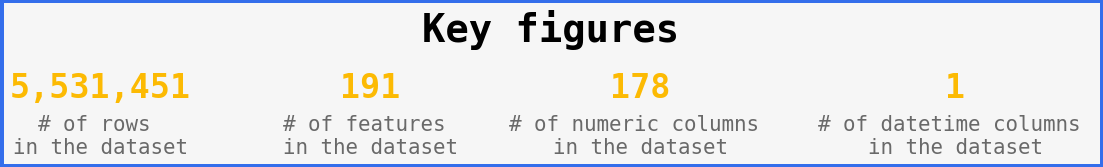

In [11]:
mpl.rcParams.update(mpl.rcParamsDefault)

data = train_raw
df_dtypes = train_raw.dtypes.value_counts()

fig = plt.figure(figsize=(5,2),facecolor='white')

ax = fig.add_subplot(1,1,1)
font = 'monospace'
ax.text(1, 0.8, "Key figures",color='black',fontsize=28, fontweight='bold', fontfamily=font, ha='center')

ax.text(0, 0.4, "{:,d}".format(data.shape[0]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(0, 0.001, "# of rows \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font,ha='center')

ax.text(0.6, 0.4, "{}".format(data.shape[1]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(0.6, 0.001, "# of features \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font,ha='center')

ax.text(1.2, 0.4, "{}".format(len(data.select_dtypes(np.number).columns)), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(1.2, 0.001, "# of numeric columns \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font, ha='center')

ax.text(1.9, 0.4,"{}".format(len(data.select_dtypes('datetime').columns)), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(1.9, 0.001,"# of datetime columns \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font,ha='center')

ax.set_yticklabels('')
ax.tick_params(axis='y',length=0)
ax.tick_params(axis='x',length=0)
ax.set_xticklabels('')

for direction in ['top','right','left','bottom']:
    ax.spines[direction].set_visible(False)

fig.subplots_adjust(top=0.9, bottom=0.2, left=0, hspace=1)

fig.patch.set_linewidth(5)
fig.patch.set_edgecolor('#346eeb')
fig.patch.set_facecolor('#f6f6f6')
ax.set_facecolor('#f6f6f6')
    
plt.show()

In [12]:
#Missing data
tmp = train_raw.isna().sum().div(len(train_raw)).mul(100).sort_values(ascending=False)

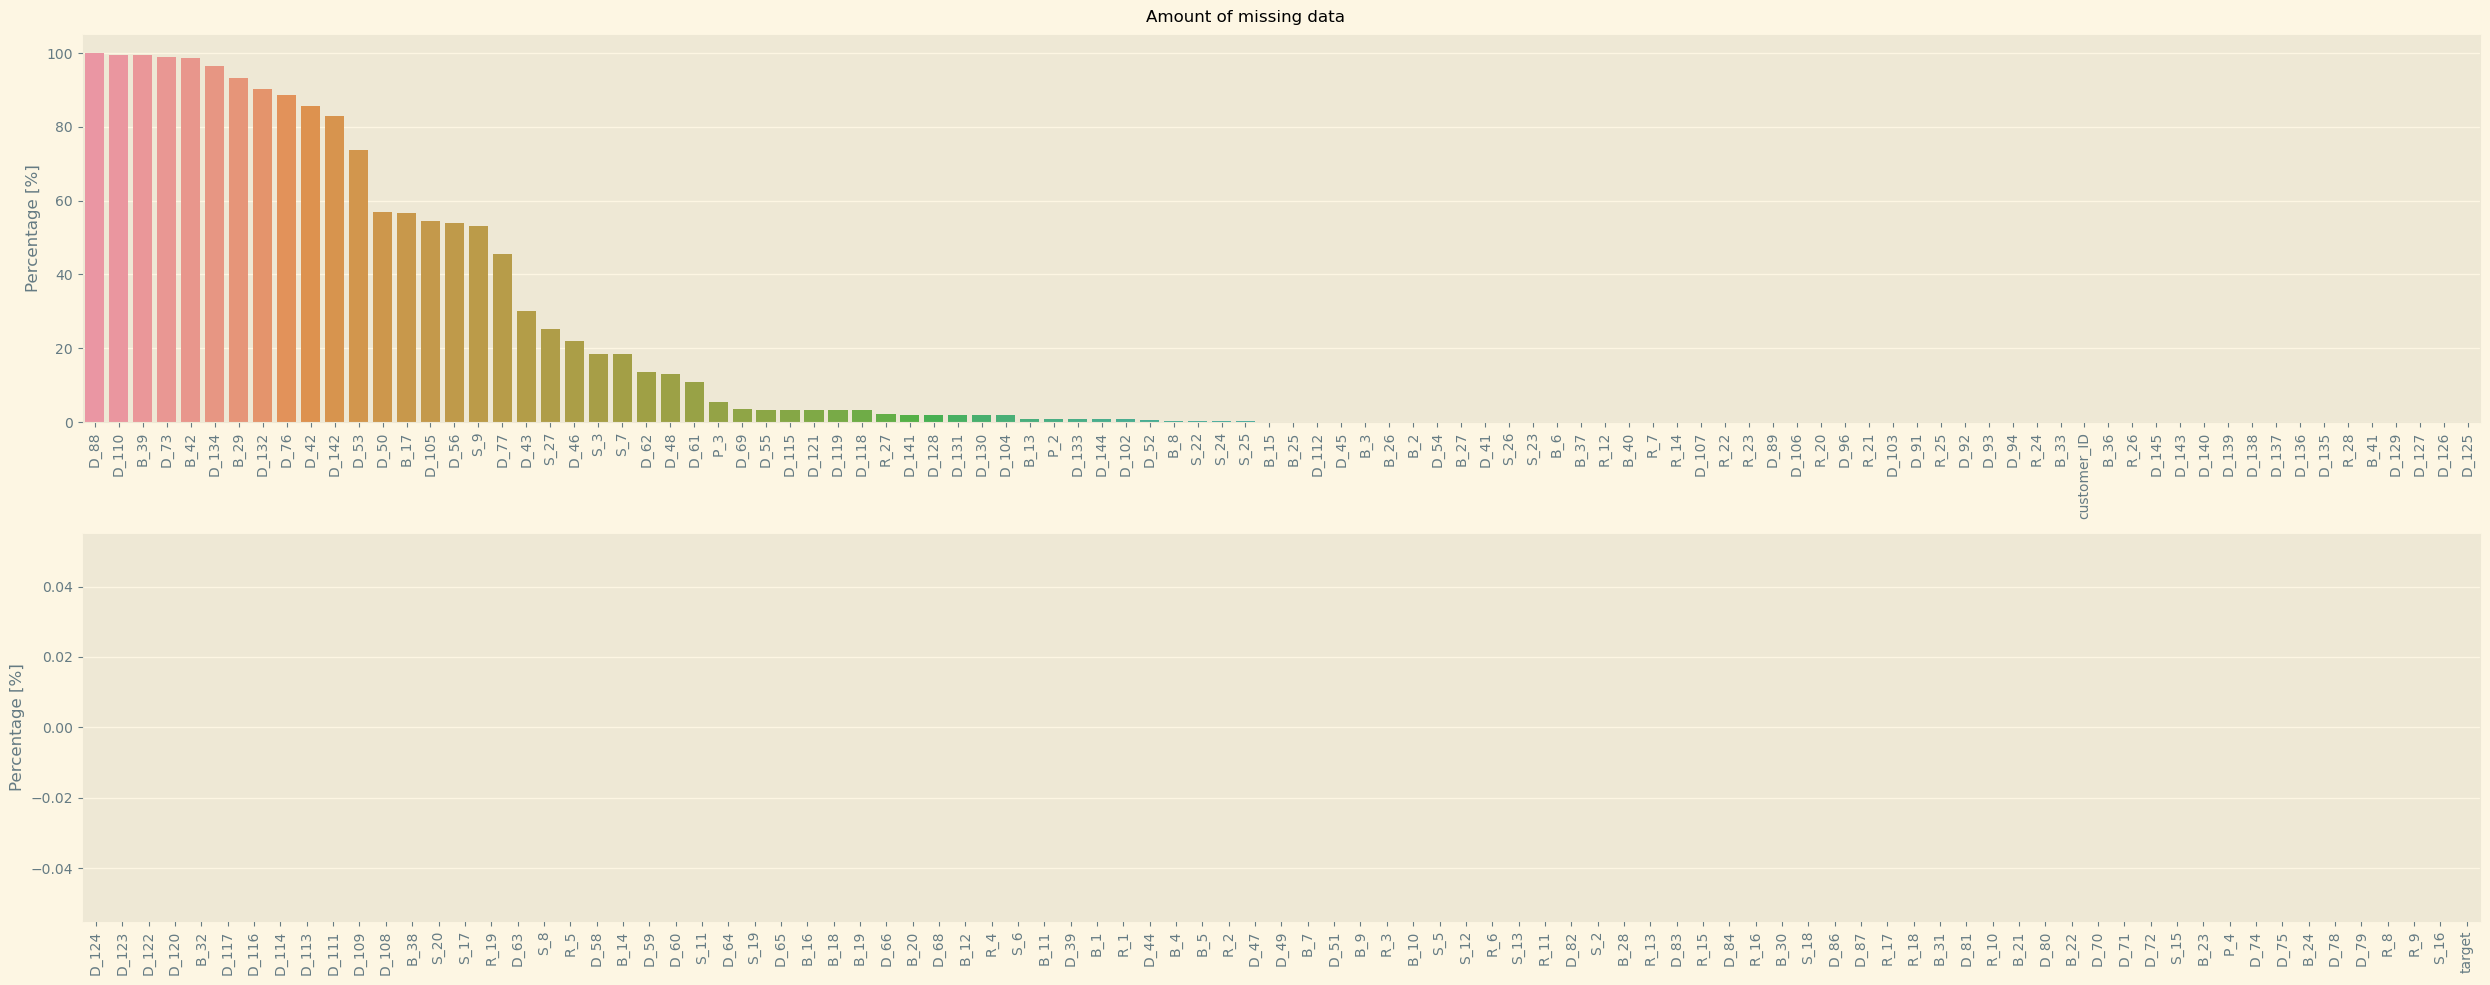

In [13]:
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots(2,1, figsize=(25,10))
sns.barplot(x=tmp[:100].index, y=tmp[:100].values, ax=ax[0])
sns.barplot(x=tmp[100:].index, y=tmp[100:].values, ax=ax[1])
ax[0].set_ylabel("Percentage [%]"), ax[1].set_ylabel("Percentage [%]")
ax[0].tick_params(axis='x', rotation=90); ax[1].tick_params(axis='x', rotation=90)
plt.suptitle("Amount of missing data")
plt.tight_layout()
plt.show()

In [14]:
#Distribution of the target variable

In [15]:
tmp = train_raw['target'].value_counts().div(len(train_raw)).mul(100)

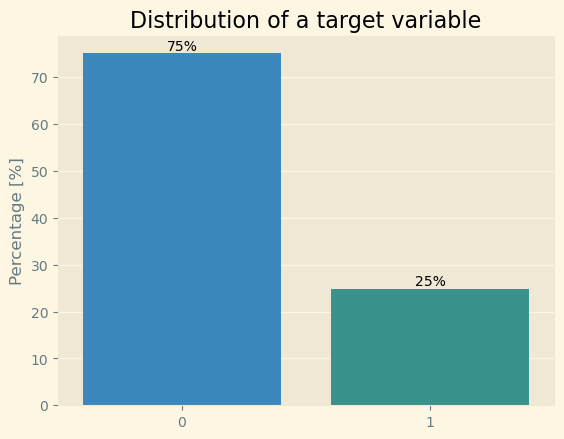

In [16]:
ax = sns.barplot(x=tmp.index, y=tmp.values)
ax.bar_label(ax.containers[0], fmt='%.f%%')
plt.title("Distribution of a target variable")
plt.ylabel("Percentage [%]")
plt.show()

It's clear that our dataset is unbalanced and this is a crucial point to keep in mind while modelling. 25% of customers had a default - it will be worth investigating these two groups separately to find some differences. First let's see how many unique customers do we have.

In [17]:
print(f'Number of unique customers: {train_raw["customer_ID"].nunique()}')

Number of unique customers: 458913


In [18]:
#Customer presence

In [19]:
cust_presence = train_raw.groupby(['customer_ID','target']).size().reset_index().rename(columns={0:'presence'})
cust_presence.head()

,customer_ID,target,presence
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,13
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,13
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,13
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,13
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,13


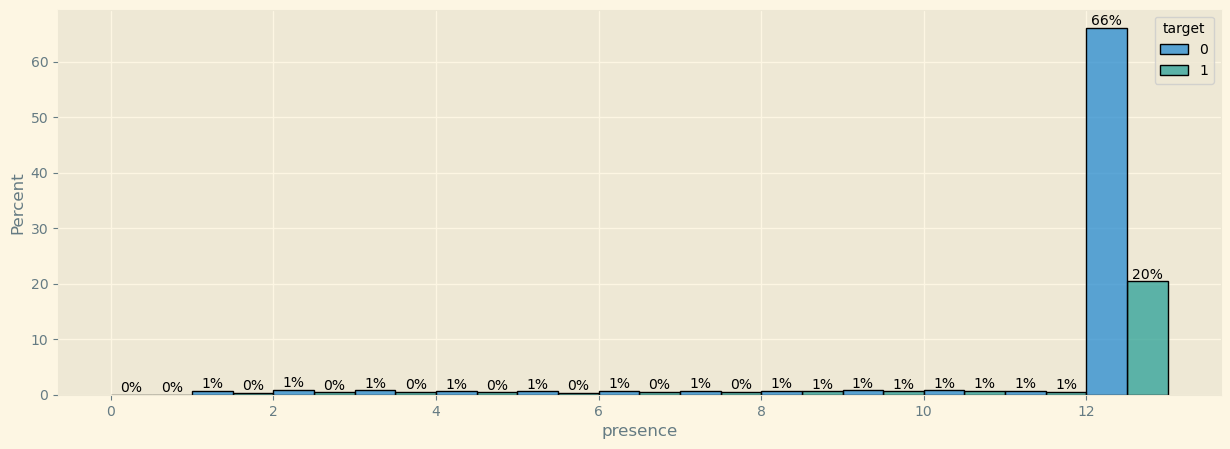

In [20]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.histplot(x='presence', data=cust_presence, hue='target', stat='percent', multiple="dodge", bins=np.arange(0,14), ax=ax)
ax.bar_label(ax.containers[0], fmt='%.f%%')
ax.bar_label(ax.containers[1], fmt='%.f%%')
plt.show()

The plot above shows how long are customer present in a dataset. It shows that 93% of them are visible for the entire full year. It's difficult from this graph to see how targets are distributed for the remaining customers, so let's zoom.

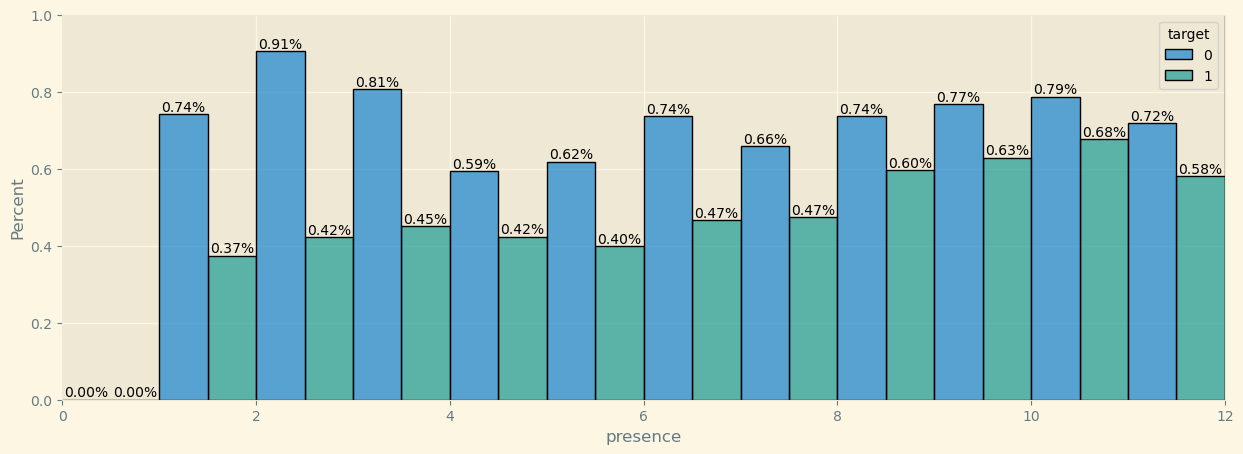

In [21]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.histplot(x='presence', data=cust_presence, hue='target', stat='percent', multiple="dodge", bins=np.arange(0,14), ax=ax)
ax.bar_label(ax.containers[0], fmt='%.2f%%')
ax.bar_label(ax.containers[1], fmt='%.2f%%')
ax.set_xlim(0,12)
ax.set_ylim(0,1)
plt.show()

In [22]:
#Correlations

#Before we dive in into distributions of the individual features let's check are there any highly correlated ones. Because it 
#would take ags to calculate the entire correlation matrix I'll use an approximate method by using a sample of 25% of customers.

In [23]:
def sample_full_cust(df, cust_ratio):
    n_customers = df['customer_ID'].nunique()
    no_of_cust = int(n_customers*cust_ratio)
    cust_ids = np.random.choice(df['customer_ID'].unique(), no_of_cust)
    print(f'Number of customers sampled: {no_of_cust}')
    ready_df = df[df['customer_ID'].isin(cust_ids)]
    print(f'Number of rows sampled: {len(ready_df)} ({round(len(ready_df)/len(df)*100)}%)')
    return ready_df

In [24]:
train_samples = sample_full_cust(train_raw, 0.55)

Number of customers sampled: 252402
Number of rows sampled: 2343246 (42%)


In [25]:
correlations = train_samples.corr().abs()

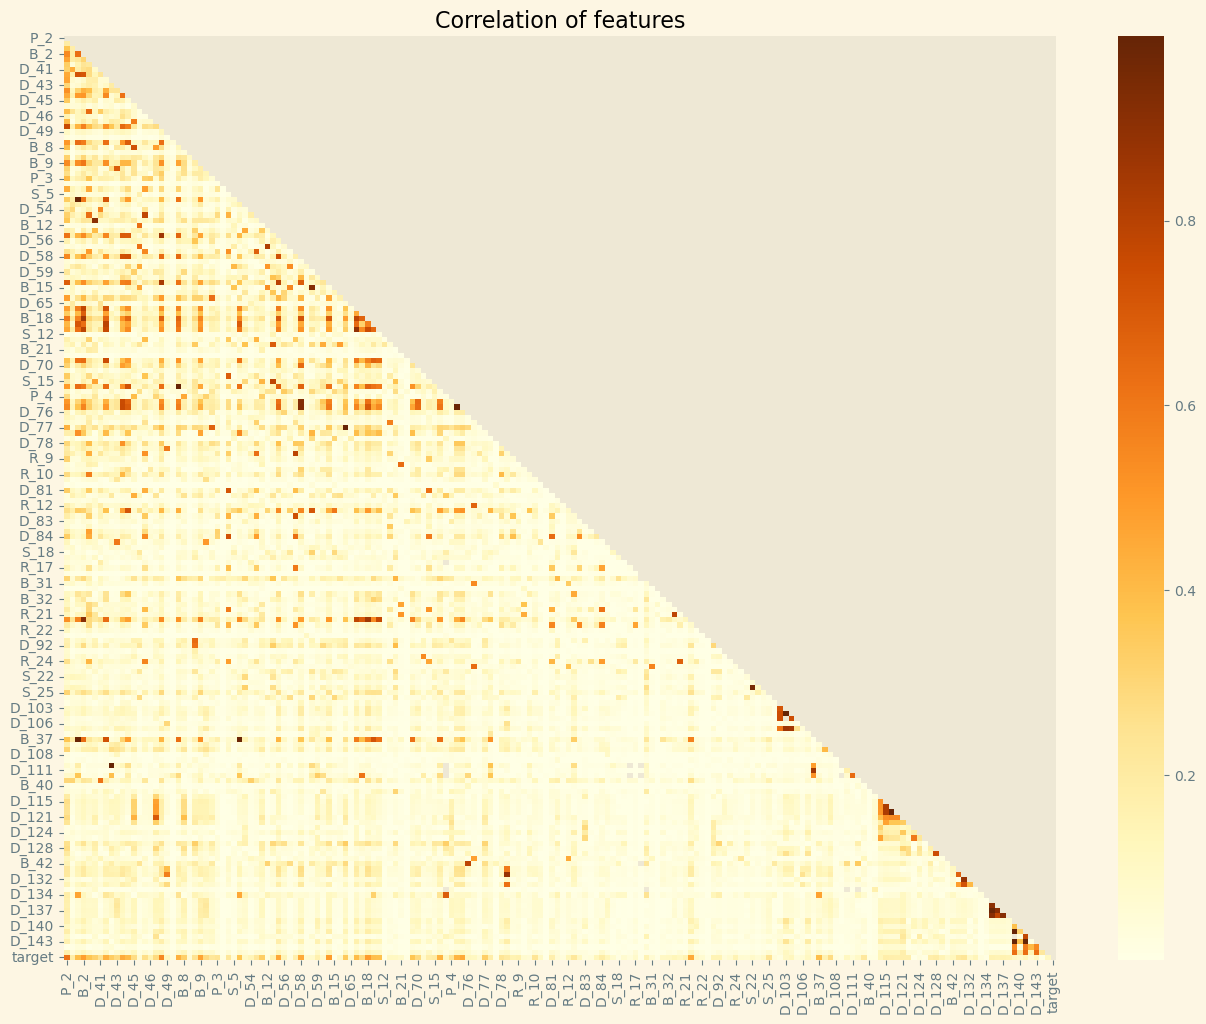

In [26]:
mask=np.triu(np.ones_like(correlations))

fig, ax = plt.subplots(1,1, figsize=(16,12))
sns.heatmap(correlations, ax=ax, mask=mask, cmap='YlOrBr')
ax.set_title("Correlation of features")
plt.show()

In [27]:
#The graph above shows us that most of features is not correlated but there are visible dark 'pixels' meaning we have some highly-correlated 
# ones. In order to print them from the most correlated to the least we have to unstack the results.

In [28]:
unstacked = correlations.unstack()
unstacked = unstacked.sort_values(ascending=False, kind="quicksort").drop_duplicates().head(25)
unstacked

P_2    P_2      1.000000
D_110  D_42     0.999798
D_77   D_62     0.999783
D_103  D_104    0.999779
D_139  D_143    0.999667
       D_141    0.998248
D_141  D_143    0.997827
B_1    B_11     0.995324
B_7    B_23     0.994992
D_119  D_118    0.994809
B_37   B_1      0.992958
       B_11     0.987719
D_75   D_74     0.987668
D_137  D_135    0.983712
S_22   S_24     0.955281
D_58   D_75     0.925697
D_74   D_58     0.922442
D_137  D_138    0.921128
B_15   B_14     0.918802
B_33   B_2      0.912789
D_135  D_138    0.910952
D_136  D_137    0.907080
S_3    S_7      0.904071
D_135  D_136    0.902716
B_16   B_20     0.888576
dtype: float64

In [29]:
#Indeed we have a lot of highly correlated features

In [30]:
#Categorical features

In [31]:
train_raw[categorical_features].sample(10)

,B_30,B_38,D_63,D_64,D_66,D_68,D_114,D_116,D_117,D_120,D_126
3435145,0,3,3,2,-1,6,1,0,0,0,2
256373,0,1,3,0,-1,6,0,0,0,0,2
5191044,0,2,3,3,-1,6,0,0,6,0,2
2081504,0,1,4,0,-1,6,1,0,5,0,2
4696629,0,2,0,2,-1,3,0,0,0,0,2
426568,0,1,3,0,-1,5,0,0,0,0,2
4002583,1,6,3,3,-1,3,0,0,4,0,2
704596,0,3,0,0,-1,6,1,0,6,0,2
2446898,0,2,3,0,-1,6,1,0,6,0,0
4054172,1,4,3,3,-1,1,0,0,3,1,1


In [32]:
#What are the unique values per categorical column?

In [33]:
for cf in categorical_features:
    print(cf, list(train_raw[cf].unique()))

B_30 [0, 2, 1, -1]
B_38 [2, 1, 3, 5, 6, 7, 4, -1]
D_63 [0, 3, 4, 1, 2, 5]
D_64 [0, 2, -1, 3, 1]
D_66 [-1, 1, 0]
D_68 [6, 2, 3, -1, 5, 4, 0, 1]
D_114 [1, 0, -1]
D_116 [0, -1, 1]
D_117 [5, 0, 7, 3, 2, -1, 4, 6]
D_120 [0, 1, -1]
D_126 [2, -1, 1, 0]


In [34]:
#How many missing values ber category?

In [35]:
train_raw[categorical_features].isna().sum().div(len(train_raw)).sort_values(ascending=False)

B_30     0.0
B_38     0.0
D_63     0.0
D_64     0.0
D_66     0.0
D_68     0.0
D_114    0.0
D_116    0.0
D_117    0.0
D_120    0.0
D_126    0.0
dtype: float64